# Graph Coloring Algorithms

1. Greedy algorithm
2. A Graph Neural Network (GNN) based approach


The graphs are read from text files where each line represents an edge in the format:
```
e v1 v2
```
Where:
- `e` indicates this line defines an edge
- `v1` and `v2` are the vertex numbers (typically 1-indexed) that are connected by this edge

For example, a line `e 1 2` means there is an edge connecting vertex 1 and vertex 2.


In this implementation, we use PyTorch Geometric (PyG) to represent graphs:
- Vertices are represented as nodes with one-hot encoded features
- Edges are stored in an `edge_index` tensor of shape [2, num_edges], where each column represents an edge
- The first row contains source nodes, and the second row contains target nodes
- Edges are undirected by adding both directions (v1→v2 and v2→v1)

In [ ]:
!pip install torch_geometric
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def load_graph_from_file(file_path):
    edges = []

    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3 and parts[0] == 'e':
                v1, v2 = int(parts[1]), int(parts[2])
                edges.append([v1-1, v2-1])

    if edges:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_index_reverse = torch.stack([edge_index[1], edge_index[0]], dim=0)
        edge_index = torch.cat([edge_index, edge_index_reverse], dim=1)

        num_nodes = edge_index.max().item() + 1
    else:
        edge_index = torch.tensor([], dtype=torch.long).reshape(2, 0)
        num_nodes = 0
    print(edge_index)
    return edge_index, num_nodes

In [ ]:
def create_pyg_data(edge_index, num_nodes):
    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    return data

In [ ]:
def visualize_graph(data, title="Graph", node_colors=None):
    G = to_networkx(data, to_undirected=True)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)

    if node_colors is not None:
        color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        node_colors = [color_map[c % len(color_map)] for c in node_colors]
        nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')
    else:
        nx.draw(G, pos, with_labels=True, node_size=500, font_weight='bold')

    plt.title(title)
    plt.show()

In [ ]:
example_files = ['test1.txt']
example_data = []

tensor([[  0,   1,   2,  ..., 117,   6,  35],
        [ 35,  44,  73,  ..., 137, 137, 137]])
Graph 1: 138 nodes, 986 edges


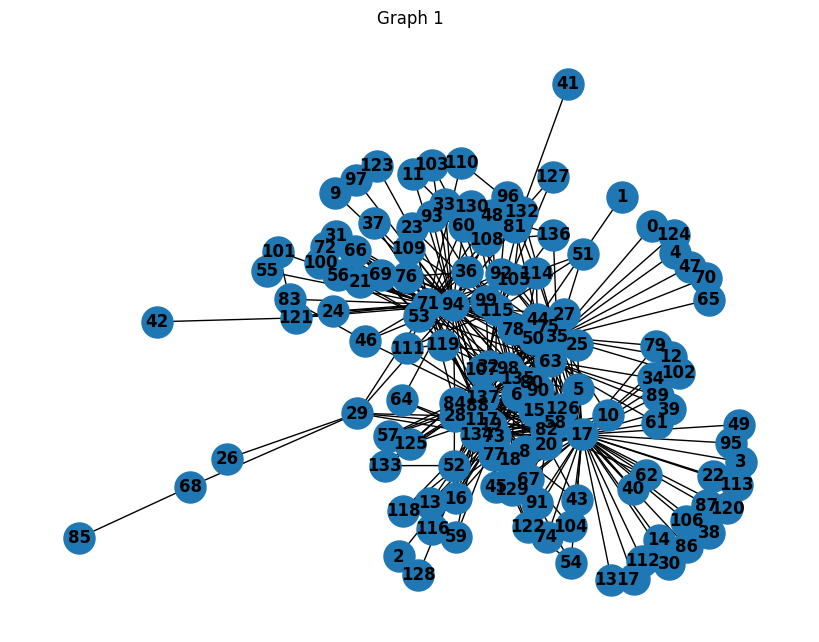

In [ ]:
for i, file_path in enumerate(example_files):
    edge_index, num_nodes = load_graph_from_file(file_path)
    data = create_pyg_data(edge_index, num_nodes)
    example_data.append(data)

    print(f"Graph {i+1}: {num_nodes} nodes, {edge_index.shape[1]//2} edges")
    visualize_graph(data, title=f"Graph {i+1}")

## Greedy Graph Coloring Algorithm

1. Sort nodes by degree (number of connections) in descending order
2. For each node, assign the smallest color (starting from 0) that is not used by any of its neighbors


In [ ]:
def greedy_coloring(data):
    G = to_networkx(data, to_undirected=True)
    colors = {}
    nodes_by_degree = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)

    for node in nodes_by_degree:
        neighbor_colors = {colors[neighbor] for neighbor in G.neighbors(node) if neighbor in colors}

        color = 0
        while color in neighbor_colors:
            color += 1

        colors[node] = color

    color_list = [colors[i] for i in range(len(G.nodes()))]
    num_colors = len(set(color_list))

    return color_list, num_colors

Graph 1 - Greedy coloring uses 11 colors
Color assignments: [0, 0, 0, 1, 0, 5, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 0, 0, 4, 7, 2, 1, 1, 0, 1, 4, 1, 2, 1, 0, 1, 0, 6, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 4, 2, 0, 0, 1, 1, 4, 0, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 3, 0, 0, 1, 1, 1, 1, 0, 4, 5, 3, 1, 5, 3, 1, 3, 2, 9, 1, 7, 1, 7, 0, 1, 1, 2, 2, 10, 4, 0, 4, 2, 2, 1, 0, 8, 3, 6, 0, 3, 3, 1, 3, 1, 8, 1, 0, 1, 0, 1, 1, 3, 7, 1, 3, 0, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 4, 2, 2, 0, 0, 4, 6, 0, 5]


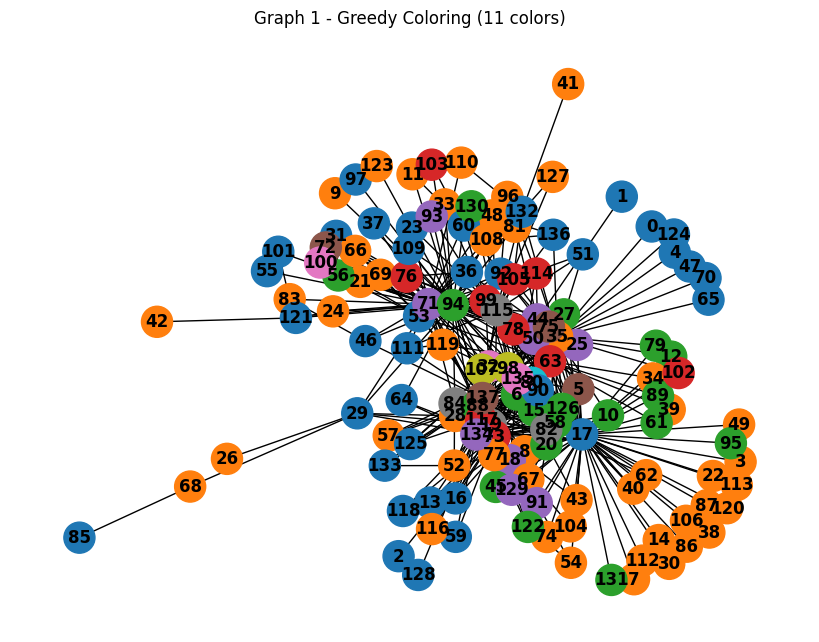

In [ ]:
for i, data in enumerate(example_data):
    colors, num_colors = greedy_coloring(data)
    print(f"Graph {i+1} - Greedy coloring uses {num_colors} colors")
    print(f"Color assignments: {colors}")
    visualize_graph(data, title=f"Graph {i+1} - Greedy Coloring ({num_colors} colors)", node_colors=colors)

## Graph Neural Network (GNN)

1. Three Graph Convolutional Network (GCN) layers
2. Two fully connected layers to predict color probabilities
3. A custom prediction method that ensures no adjacent nodes have the same color

In [ ]:
class GNNColoringModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, max_colors=10):
        super(GNNColoringModel, self).__init__()
        self.max_colors = max_colors

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, max_colors)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

    def predict_colors(self, x, edge_index):
        self.eval()
        with torch.no_grad():
            logits = self(x, edge_index)
            print(logits)
            edge_list = edge_index.t().tolist()
            G = nx.Graph()
            G.add_nodes_from(range(x.size(0)))
            G.add_edges_from(edge_list)

            color_prefs = F.softmax(logits, dim=1).cpu().numpy()
            print(color_prefs)

            colors = {}
            nodes_by_degree = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)

            for node in nodes_by_degree:
                neighbor_colors = {colors[neighbor] for neighbor in G.neighbors(node) if neighbor in colors}
                node_prefs = np.argsort(-color_prefs[node])

                for color in node_prefs:
                    if color not in neighbor_colors:
                        colors[node] = int(color)
                        break
                else:
                    color = 0
                    while color in neighbor_colors:
                        color += 1
                    colors[node] = color

            color_list = [colors[i] for i in range(len(G.nodes()))]
            return color_list

## Custom Loss Function
 **Adjacency Loss**: Penalizes when connected nodes have similar color probabilities
   - For each edge (src, dst), we calculate the dot product of their color probability distributions
   - Higher dot product means more similar distributions (bad for graph coloring)
   - We want connected nodes to have different colors, so we minimize this similarity

In [ ]:
def coloring_loss(logits, edge_index, diversity_weight=0.1):
    probs = F.softmax(logits, dim=1)
    src, dst = edge_index
    src_probs = probs[src]
    dst_probs = probs[dst]

    similarity = torch.sum(src_probs * dst_probs, dim=1)

    adjacency_loss = similarity.mean()

    total_loss = adjacency_loss

    return total_loss

In [ ]:
def train_gnn_coloring(data, hidden_channels=64, max_colors=10, epochs=200, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNNColoringModel(data.x.size(1), hidden_channels, max_colors).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    data = data.to(device)
    losses = []

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(data.x, data.edge_index)
        loss = coloring_loss(logits, data.edge_index)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')

    return model, losses


Training GNN for Graph 1
Epoch 020, Loss: 0.1000
Epoch 040, Loss: 0.1000
Epoch 060, Loss: 0.1000
Epoch 080, Loss: 0.1000
Epoch 100, Loss: 0.1000
Epoch 120, Loss: 0.1000
Epoch 140, Loss: 0.1000
Epoch 160, Loss: 0.0822
Epoch 180, Loss: 0.0680
Epoch 200, Loss: 0.0688
GNN training execution time: 1.5715 seconds


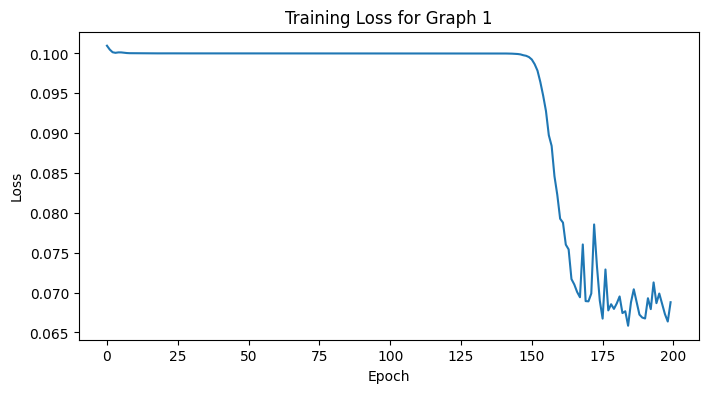

tensor([[ 3.3210, -5.6727,  3.4884,  ...,  3.6864, -5.7093,  3.7444],
        [ 3.3258, -5.6801,  3.4952,  ...,  3.6898, -5.7208,  3.7504],
        [ 3.3216, -5.6737,  3.4893,  ...,  3.6869, -5.7108,  3.7451],
        ...,
        [-0.1534,  0.3314, -0.9883,  ..., -1.4995,  0.3068, -1.9973],
        [ 3.3338, -5.6925,  3.5068,  ...,  3.6956, -5.7402,  3.7606],
        [-2.7374,  4.7687, -4.3281,  ..., -5.3689,  4.7700, -6.2723]])
[[1.23107947e-01 1.52886314e-05 1.45536840e-01 ... 1.77414387e-01
  1.47395886e-05 1.87994942e-01]
 [1.23098329e-01 1.51030581e-05 1.45832896e-01 ... 1.77158132e-01
  1.45005406e-05 1.88222155e-01]
 [1.23106718e-01 1.52642242e-05 1.45575568e-01 ... 1.77380890e-01
  1.47080891e-05 1.88024655e-01]
 ...
 [5.37909083e-02 8.73431042e-02 2.33404767e-02 ... 1.39983706e-02
  8.52217078e-02 8.50976072e-03]
 [1.23081550e-01 1.47946948e-05 1.46333575e-01 ... 1.76725477e-01
  1.41055425e-05 1.88605845e-01]
 [1.61167802e-04 2.93186694e-01 3.28448368e-05 ... 1.15999665e-05


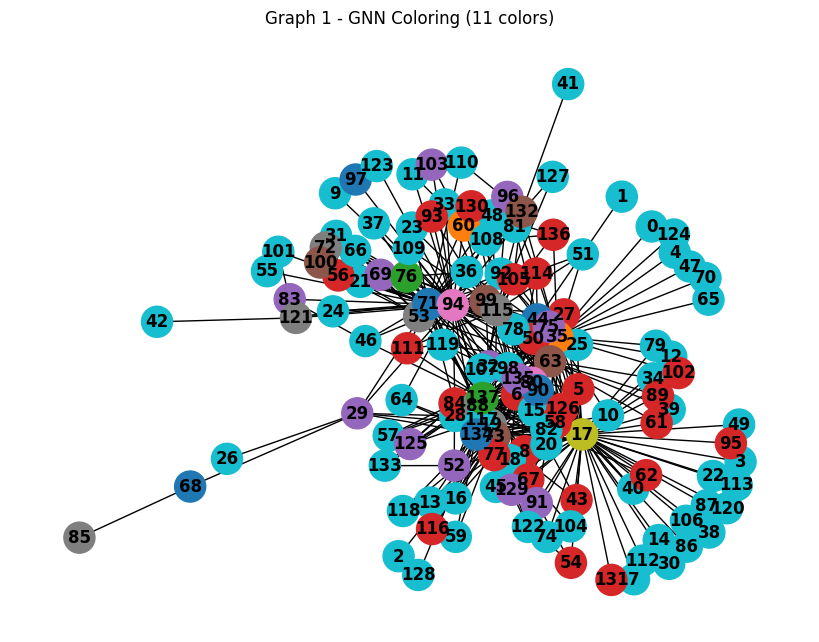

In [ ]:
gnn_results = []
for i, data in enumerate(example_data):
    print(f"\nTraining GNN for Graph {i+1}")
    start_time = time.time()
    model, losses = train_gnn_coloring(data, hidden_channels=32, max_colors=10, epochs=200)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"GNN training execution time: {execution_time:.4f} seconds")
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss for Graph {i+1}')
    plt.show()

    colors = model.predict_colors(data.x, data.edge_index)
    num_colors = len(set(colors))

    print(f"GNN coloring for Graph {i+1} uses {num_colors} colors")
    print(f"Color assignments: {colors}")

    visualize_graph(data, title=f"Graph {i+1} - GNN Coloring ({num_colors} colors)", node_colors=colors)

    gnn_results.append((colors, num_colors))

In [ ]:
def verify_coloring(data, colors):
    edge_index = data.edge_index
    conflicts = []

    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i].item(), edge_index[1, i].item()
        if colors[src] == colors[dst]:
            conflicts.append((src, dst))

    is_valid = len(conflicts) == 0
    return is_valid, conflicts

## Comparison: Greedy and GNN Coloring Results


In [ ]:
for i, data in enumerate(example_data):
    start_time = time.time()
    greedy_colors, greedy_num_colors = greedy_coloring(data)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Greedy coloring execution time: {execution_time:.4f} seconds")
    gnn_colors, gnn_num_colors = gnn_results[i]

    print(f"Graph {i+1} comparison:")
    print(f"  - Greedy algorithm: {greedy_num_colors} colors")
    print(f"  - GNN approach: {gnn_num_colors} colors")

    greedy_valid, greedy_conflicts = verify_coloring(data, greedy_colors)
    gnn_valid, gnn_conflicts = verify_coloring(data, gnn_colors)

    print(f"  - Greedy coloring valid: {greedy_valid}")
    print(f"  - GNN coloring valid: {gnn_valid}")

    if not greedy_valid:
        print(f"    Greedy conflicts: {greedy_conflicts}")
    if not gnn_valid:
        print(f"    GNN conflicts: {gnn_conflicts}")

    print()

Greedy coloring execution time: 0.0109 seconds
Graph 1 comparison:
  - Greedy algorithm: 11 colors
  - GNN approach: 11 colors
  - Greedy coloring valid: True
  - GNN coloring valid: True



## Summary

In this notebook, we've explored two approaches to graph coloring:

1. **Greedy Algorithm**:
   - Simple and fast
   - Processes nodes in order of degree (most connected first)
   - Assigns the smallest available color to each node

2. **Graph Neural Network (GNN)**:
   - More sophisticated approach using deep learning
   - Learns node embeddings that capture graph structure
   - Uses a custom loss function to encourage proper coloring
   - Can potentially find better colorings for complex graphs

Both approaches ensure that no adjacent nodes have the same color, which is the fundamental requirement of graph coloring.